In [7]:
import numpy as np
import matplotlib.pyplot as plt
from os import listdir, remove

import jax.numpy as jnp
from scico import functional, linop, loss, metric
from scico.optimize import PDHG

import optuna

from src.forward_operator.forward_operator import forward_operator
from src.forward_operator.operators import *

from src.inversions.baseline_method.inversion_baseline import *

from src.input_initialization import initialize_input

In [19]:
CFA = 'sony'
BINNING = CFA == 'quad_bayer'
NOISE_LEVEL = 0

INPUT_DIR = 'input/ms/'

In [20]:
x, spectral_stencil = initialize_input(INPUT_DIR + 'W4_Mexi_Nat_rgb.png')

cfa_op = cfa_operator(CFA, x.shape, spectral_stencil, 'dirac')
forward_op = forward_operator([cfa_op])
baseline_inverse = Inverse_problem(CFA, BINNING, 0, x.shape, spectral_stencil, 'dirac')

def forward_pass(x):
    return jnp.array(forward_op.direct(x))

def adjoint_pass(y):
    return jnp.array(forward_op.adjoint(y))

A = linop.LinearOperator(input_shape=x.shape, output_shape=x.shape[:-1], eval_fn=forward_pass, adj_fn=adjoint_pass)

C = linop.FiniteDifference(input_shape=x.shape, append=0, axes=(0, 1))
C_squared_norm = np.float64(linop.operator_norm(C))**2

y = np.clip(forward_op.direct(x) + np.random.normal(0, NOISE_LEVEL / 100, forward_op.output_shape), 0, 1)

f = loss.SquaredL2Loss(y=jnp.array(y), A=A)

x_baseline = jnp.array(baseline_inverse(y)[:, :, ::-1])

def objective(trial):
    lambd = trial.suggest_float('lambd', 1e-3, 0.2, log=True)
    sigma = trial.suggest_float('sigma', 1e-2, 100, log=True)
    tmp = trial.suggest_float('tmp', 1e-3, 1)
    tau = tmp / (sigma * C_squared_norm)

    g = lambd * functional.L21Norm(l2_axis=(0, 3))

    solver_TV = PDHG(
        f=f,
        g=g,
        C=C,
        tau=tau,
        sigma=sigma,
        x0=x_baseline,
        maxiter=400
    )

    return metric.mse(x, solver_TV.solve())

study = optuna.create_study(direction='minimize', storage='sqlite:///main.sqlite3', study_name='tv', load_if_exists=True)
study.optimize(objective, n_trials=10)
best_trial = study.best_trial



[I 2023-05-30 10:48:14,230] Using an existing study with name 'tv' instead of creating a new one.
[I 2023-05-30 10:48:33,423] Trial 20 finished with value: 0.0017111124470829964 and parameters: {'lambd': 0.001824379931252395, 'sigma': 0.03367620614408311, 'tmp': 0.2950229738132264}. Best is trial 5 with value: 0.001578051596879959.
[I 2023-05-30 10:48:53,375] Trial 21 finished with value: 0.0017027619760483503 and parameters: {'lambd': 0.0020275282411428837, 'sigma': 0.07088893739093469, 'tmp': 0.5004616167185045}. Best is trial 5 with value: 0.001578051596879959.
[I 2023-05-30 10:49:12,455] Trial 22 finished with value: 0.001741217216476798 and parameters: {'lambd': 0.00378937612563924, 'sigma': 0.09869083966374596, 'tmp': 0.5058130175103438}. Best is trial 5 with value: 0.001578051596879959.
[I 2023-05-30 10:49:32,162] Trial 23 finished with value: 0.0017099817050620914 and parameters: {'lambd': 0.0018284390716535339, 'sigma': 0.029116291269663048, 'tmp': 0.25077269470045593}. Best i

KeyboardInterrupt: 

In [21]:
g = 0.002028 * functional.L21Norm(l2_axis=(0, 3))
sigma = 0.07089
tau = 0.50046 / (sigma * C_squared_norm)

solver_TV = PDHG(
    f=f,
    g=g,
    C=C,
    tau=tau,
    sigma=sigma,
    x0=x_baseline,
    maxiter=400
)

res = np.array(solver_TV.solve())

np.clip(res, 0, 1, res)

array([[[1.5886892e-02, 0.0000000e+00, 1.0295845e-01],
        [2.3038167e-01, 1.7560636e-01, 3.0423015e-01],
        [2.3209350e-01, 1.5398496e-01, 2.6987770e-01],
        ...,
        [8.7682712e-01, 8.3950293e-01, 9.1235733e-01],
        [9.0572405e-01, 8.5635614e-01, 9.1430199e-01],
        [8.3896774e-01, 7.9879534e-01, 8.1014824e-01]],

       [[4.4416733e-02, 7.9294577e-02, 1.5147299e-01],
        [2.9416710e-01, 2.5009674e-01, 3.1198671e-01],
        [2.9859528e-01, 2.4025528e-01, 3.0865011e-01],
        ...,
        [8.4100193e-01, 7.9480433e-01, 8.5514003e-01],
        [8.2772946e-01, 7.3566264e-01, 8.0863595e-01],
        [8.3227545e-01, 7.7966821e-01, 8.0037022e-01]],

       [[5.3554993e-02, 5.6435657e-04, 5.5874936e-02],
        [2.8653187e-01, 2.5419763e-01, 2.9536915e-01],
        [2.4080515e-01, 2.2137563e-01, 2.3033868e-01],
        ...,
        [7.9290146e-01, 7.1849579e-01, 7.7016175e-01],
        [7.8200144e-01, 7.1084958e-01, 7.4470580e-01],
        [7.8714073e-01

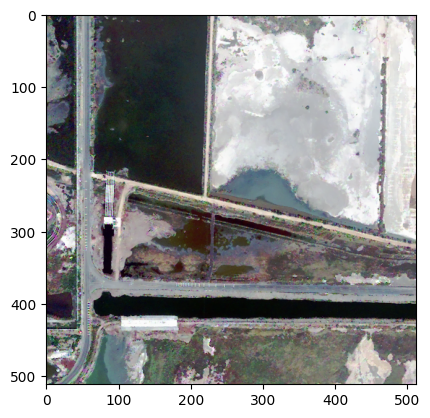

In [22]:
plt.imshow(res)
plt.imsave(f'{CFA}.png', res)